In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os 
import seaborn 
import keras
from google.colab import drive 
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [1]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import random
import warnings 
warnings.filterwarnings('ignore')


In [4]:
device_list = tf.test.gpu_device_name()
if device_list != '/device:GPU:0':
   raise SystemError('GPU device not found')
print("GPU found at : {}".format(device_list))
!nvidia-smi


GPU found at : /device:GPU:0
Thu Sep 15 14:48:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    29W /  70W |    284MiB / 15109MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                           

In [5]:
#image size et batch size
image_size = (224, 224)
batch_size = 32 

In [6]:
#path vers le dossier flowers
dossier_flower = '/content/drive/MyDrive/flowers'

In [7]:
from pandas.io.formats.style_render import Subset
#training data 
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    dossier_flower,
    subset = 'training',
    validation_split = 0.2,
    image_size = image_size,
    batch_size = batch_size,
    seed = 42
)

Found 3683 files belonging to 5 classes.
Using 2947 files for training.


In [8]:
#testing data 
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    dossier_flower,
    subset = 'validation',
    validation_split = 0.2,
    image_size = image_size,
    batch_size = batch_size,
    seed = 42
)

Found 3683 files belonging to 5 classes.
Using 736 files for validation.


In [9]:
class_names = train_data.class_names
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [10]:
#encoder les classes names pour les rendre des chiffres

In [10]:
label_encoder = LabelEncoder()
class_names_label_encoder = label_encoder.fit_transform(class_names)
class_names_label_encoder

array([0, 1, 2, 3, 4])

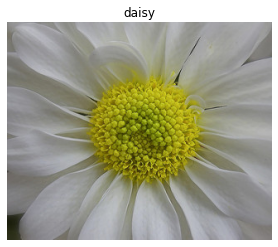

In [12]:
#montrer une photo 
image = plt.imread("/content/drive/MyDrive/flowers/daisy/100080576_f52e8ee070_n.jpg")
plt.imshow(image)
plt.title('daisy')
plt.axis('off')
plt.show()

In [40]:
image.shape

(1104, 828, 3)

In [11]:
#image processing 
def preprocess_image(image, label, image_shape=224):
  img = tf.image.resize(image, [image_shape, image_shape])
  img = img/225
  return tf.cast(img, tf.float32), label

In [41]:
preprocess_image(image=image, label='daisy').shape

AttributeError: ignored

In [12]:
#map the preprocess_image to train_data
train_data = train_data.map(map_func = preprocess_image, num_parallel_calls= tf.data.AUTOTUNE)

#shuffle the data
train_data = train_data.shuffle(buffer_size= 1000).prefetch(buffer_size = tf.data.AUTOTUNE)

#map the preprocess_image to valid data
test_data = test_data.map(map_func = preprocess_image, num_parallel_calls= tf.data.AUTOTUNE)
#shuffle the data
test_data = test_data.shuffle(buffer_size= 1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [13]:
tf.random.set_seed(42)

In [14]:
model_1 = Sequential(
    [
        Conv2D(filters= 32, kernel_size = 4, padding = 'same', activation = 'relu', input_shape = (224, 224, 3)),
        MaxPool2D(2,2),
        Conv2D(filters= 64, kernel_size = 4, padding = 'same', activation = 'relu', input_shape = (224, 224, 3)),
        MaxPool2D(2,2),
        Conv2D(filters= 64, kernel_size = 4, padding = 'same', activation = 'relu', input_shape = (224, 224, 3)),
        MaxPool2D(2,2),
        Dropout(0.5), #reduire l'overfitting lors de l'entrainement du model (desactiver temporairement certains neurones dans le reseau + toutes ses connexions, le choix de ces neurones est aleatoire)
        Flatten(),
        Dense(len(class_names_label_encoder), activation = 'softmax')
     
    ]
)



In [15]:
device_list = tf.test.gpu_device_name()
if device_list != '/device:GPU:0':
   raise SystemError('GPU device not found')
print("GPU found at : {}".format(device_list))

!nvidia-smi

GPU found at : /device:GPU:0
Thu Sep 15 14:49:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    29W /  70W |    290MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                           

In [16]:
#compile
model_1.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = 'adam',
                metrics=['accuracy'])

#fitting
model_1.fit(train_data, epochs = 5, validation_data = test_data)


Epoch 1/5
93/93 [==============================] - 403s 3s/step - loss: 1.3493 - accuracy: 0.4181 - val_loss: 1.1513 - val_accuracy: 0.4986
Epoch 2/5
93/93 [==============================] - 14s 81ms/step - loss: 1.0497 - accuracy: 0.5830 - val_loss: 1.0372 - val_accuracy: 0.5992
Epoch 3/5
93/93 [==============================] - 14s 82ms/step - loss: 0.9197 - accuracy: 0.6434 - val_loss: 1.1060 - val_accuracy: 0.6182
Epoch 4/5
93/93 [==============================] - 14s 81ms/step - loss: 0.7886 - accuracy: 0.7017 - val_loss: 0.9796 - val_accuracy: 0.6318
Epoch 5/5
93/93 [==============================] - 14s 82ms/step - loss: 0.6338 - accuracy: 0.7645 - val_loss: 1.0409 - val_accuracy: 0.6427


In [17]:
#transfer learning 
# Download Inception V3 model
base_model_inception = tf.keras.applications.inception_v3.InceptionV3(include_top=False)

# Freeze the layers
base_model_inception.trainable=False

# Inputs
inputs = tf.keras.layers.Input(shape=(224,224,3), name='input_layer')

# Scaling the values
x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# Pass inputs to our base_model
x = base_model_inception(inputs,training=False)

# GlobalAveragePooling2D
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# outputs
outputs = tf.keras.layers.Dense(len(class_names_label_encoder), activation='softmax')(x)

# Build model
model_4 = tf.keras.Model(inputs, outputs)

# Compile the model
model_4.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer='adam',
               metrics=['accuracy'])

In [18]:
# Fit the model
history_4 = model_4.fit(train_data,
                       epochs=5,
                       validation_data=test_data)


Epoch 1/5
93/93 [==============================] - 25s 156ms/step - loss: 0.8074 - accuracy: 0.6919 - val_loss: 0.5673 - val_accuracy: 0.7908
Epoch 2/5
93/93 [==============================] - 16s 108ms/step - loss: 0.4512 - accuracy: 0.8395 - val_loss: 0.4766 - val_accuracy: 0.8247
Epoch 3/5
93/93 [==============================] - 16s 110ms/step - loss: 0.3608 - accuracy: 0.8795 - val_loss: 0.4633 - val_accuracy: 0.8410
Epoch 4/5
93/93 [==============================] - 18s 118ms/step - loss: 0.3113 - accuracy: 0.9009 - val_loss: 0.4506 - val_accuracy: 0.8329
Epoch 5/5
93/93 [==============================] - 18s 110ms/step - loss: 0.2722 - accuracy: 0.9145 - val_loss: 0.4388 - val_accuracy: 0.8451


In [ ]:
model_4.save('my_model.h5')


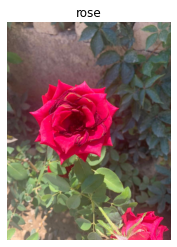

In [50]:
#montrer une photo 
image = plt.imread("/content/drive/MyDrive/flower_test.jpg")
plt.imshow(image)
plt.title('rose')
plt.axis('off')
plt.show()

In [55]:
import cv2
import numpy as np

img = cv2.imread("/content/drive/MyDrive/DAZAI.jpg")

img = cv2.resize(img,(224,224))     # resize image to match model's expected sizing
img = img.reshape(1,224,224,3) 
img = img/225
img2 = tf.cast(img, tf.float32),
print(np.argmax(model_4.predict(img2)))


0


In [56]:
import cv2
import numpy as np

img = cv2.imread("/content/drive/MyDrive/test2floww.jpg")

img = cv2.resize(img,(224,224))     # resize image to match model's expected sizing
img = img.reshape(1,224,224,3) 
img = img/225
img2 = tf.cast(img, tf.float32),
print(np.argmax(model_4.predict(img2)))

2
